In [25]:
from matplotlib import pyplot as plt

In [26]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

In [27]:
from matplotlib.patches import FancyArrowPatch

In [28]:
%matplotlib widget

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

In [29]:
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [30]:
import allel
import numpy as np
import pandas as pd
import seaborn as sns
import umap

## PCA using scikit-learn

http://alimanfoo.github.io/2015/09/28/fast-pca.html

The data:

In [ ]:
vcf = allel.read_vcf('../steps/recode_vcf/chr7_females.recode.vcf')

In [ ]:
pop = pd.read_table('../data/females.txt', delimiter = '\t', header = None,
                   names = ['Individual', 'Population'])

In [ ]:
gt = allel.GenotypeArray(vcf['calldata/GT'])
gt

In [ ]:
ac = gt.count_alleles()
ac

Removing singletons and multiallelic SNPs.

In [ ]:
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
gf = gt.compress(flt, axis=0)
gf

The final input for sklearnPCA:

In [ ]:
gn = gf.to_n_alt()
gn

In [ ]:
sklearn_pca = sklearnPCA(n_components=2)
sklearn_transf = sklearn_pca.fit_transform(gn.T)

In [ ]:
pc1_var = sklearn_pca.explained_variance_ratio_[0].round(decimals=3)*100
pc2_var = sklearn_pca.explained_variance_ratio_[1].round(decimals=3)*100

Creating a dataframe from the resulting array and adding population names to each individual

In [ ]:
principal_df = pd.DataFrame(data = sklearn_transf, 
                           columns = ['PC1', 'PC2'])

In [ ]:
final_df = pd.concat([principal_df, pop[['Population']]], axis = 1)
final_df

In [ ]:
fig, ax = plt.subplots(figsize = (6,5))

groups = final_df.groupby('Population')
for name, group in groups:
    ax.scatter(group['PC1'], group['PC2'], label=name)

ax.set_xlabel('Principal Component 1 ({}%)'.format(pc1_var), fontsize = 10)
ax.set_ylabel('Principal Component 2 ({}%)'.format(pc2_var), fontsize = 10)
ax.set_title('Chromosome 7: Females', fontsize = 15)
ax.legend()
plt.show()

### Effect of pruning

In [ ]:
def plot_ld(gn, title):
    m = allel.rogers_huff_r(gn) ** 2
    ax = allel.plot_pairwise_ld(m)
    ax.set_title(title)
    ax.figure.set_size_inches(5, 5)
    plt.show()

In [ ]:
plot_ld(gn[:1000], 'Figure 1. Pairwise LD.')

In [ ]:
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [ ]:
gnu = ld_prune(gn, size=500, step=200, threshold=.1, n_iter=5)

In [ ]:
plot_ld(gnu[:1000], 'Figure 2. Pairwise LD after LD pruning.')

In [ ]:
# Performing the PCA analysis again
sklearn_pca_pruned = sklearnPCA(n_components=2)
pruned_pca = sklearn_pca_pruned.fit_transform(gnu.T)

# Creating a dataframe and adding population names
principal_pruned = pd.DataFrame(data = pruned_pca, 
                           columns = ['PC1', 'PC2'])
final_pruned = pd.concat([principal_pruned, pop[['Population']]], axis = 1)

# Percentage variance explained
pruned_pc1_var = sklearn_pca_pruned.explained_variance_ratio_[0].round(decimals=3)*100
pruned_pc2_var = sklearn_pca_pruned.explained_variance_ratio_[1].round(decimals=3)*100

In [ ]:
fig, ax = plt.subplots(figsize = (6,5))

groups = final_pruned.groupby('Population')
for name, group in groups:
    ax.scatter(group['PC1'], group['PC2'], label=name)

ax.set_xlabel('Principal Component 1 ({}%)'.format(pruned_pc1_var), fontsize = 10)
ax.set_ylabel('Principal Component 2 ({}%)'.format(pruned_pc2_var), fontsize = 10)
ax.set_title('Pruned chromosome 7: Females', fontsize = 15)
ax.legend()
plt.show()

### Effect of scaling

Performing the PCA analysis with scaling

In [ ]:
gn.shape

In [ ]:
pipeline = make_pipeline(StandardScaler(), sklearnPCA(n_components=2))
scaled_data_transf = pipeline.fit_transform(gn[:1800000, :].T)

Creating a dataframe and adding population names

In [ ]:
principal_scaled = pd.DataFrame(data = scaled_data_transf, 
                           columns = ['PC1', 'PC2'])
final_scaled = pd.concat([principal_scaled, pop[['Population']]], axis = 1)

Percentage variance explained

In [ ]:
pca = pipeline.get_params()['pca']

In [ ]:
scaled_pc1_var = pca.explained_variance_ratio_[0].round(decimals=3)*100
scaled_pc2_var = pca.explained_variance_ratio_[1].round(decimals=3)*100

Plotting the result

In [ ]:
fig, ax = plt.subplots(figsize = (6,5))

groups = final_scaled.groupby('Population')
for name, group in groups:
    ax.scatter(group['PC1'], group['PC2'], label=name)

ax.set_xlabel('Principal Component 1 ({}%)'.format(scaled_pc1_var), fontsize = 10)
ax.set_ylabel('Principal Component 2 ({}%)'.format(scaled_pc2_var), fontsize = 10)
ax.set_title('Scaled chromosome 7: Females', fontsize = 15)
ax.legend()
plt.show()

### Applying both pruning and scaling

In [ ]:
scaled_pruned = pipeline.fit_transform(gnu.T)

In [ ]:
principal_scaled_pruned = pd.DataFrame(data = scaled_pruned, 
                           columns = ['PC1', 'PC2'])
final_scaled_pruned = pd.concat([principal_scaled_pruned, pop[['Population']]], axis = 1)

In [ ]:
pca = pipeline.get_params()['pca']
scaled_pruned_pc1_var = pca.explained_variance_ratio_[0].round(decimals=3)*100
scaled_pruned_pc2_var = pca.explained_variance_ratio_[1].round(decimals=3)*100

In [ ]:
fig, ax = plt.subplots(figsize = (6,5))

groups = final_scaled_pruned.groupby('Population')
for name, group in groups:
    ax.scatter(group['PC1'], group['PC2'], label=name)

ax.set_xlabel('Principal Component 1 ({}%)'.format(scaled_pruned_pc1_var), fontsize = 10)
ax.set_ylabel('Principal Component 2 ({}%)'.format(scaled_pruned_pc2_var), fontsize = 10)
ax.set_title('Scaled & pruned chromosome 7: Females', fontsize = 15)
ax.legend()
plt.show()

## UMAP

In [ ]:
sns.set(style='ticks', context='notebook', rc={'figure.figsize':(9,7)})

In [ ]:
# sns.pairplot(final_df, hue='Population')

In [ ]:
reducer = umap.UMAP()

In [37]:
embedding = reducer.fit_transform(principal_scaled_pruned)
embedding.shape

(95, 2)

In [38]:
umap_df = pd.DataFrame(data = embedding,
                       columns = ['1', '2'])
final_embed = pd.concat([umap_df, pop[['Population']]], axis = 1)
final_embed

,1,2,Population
0,11.422564,6.299389,anubis
1,10.770736,5.878742,anubis
2,10.840323,6.126390,anubis
3,11.994856,6.382074,anubis
4,13.228243,6.602378,anubis
...,...,...,...
90,-2.923056,11.078491,kindae
91,-2.987473,10.944667,kindae
92,-2.892263,11.040895,kindae
93,-2.925820,11.006926,kindae


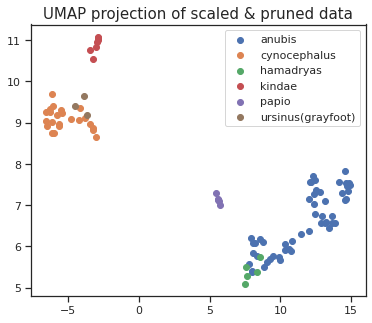

In [49]:
fig, ax = plt.subplots(figsize = (6,5))

groups = final_embed.groupby('Population')
for name, group in groups:
    ax.scatter(group['1'], group['2'], label=name)

ax.set_title('UMAP projection of scaled & pruned data', fontsize = 15)
ax.legend()
plt.show()